<a href="https://colab.research.google.com/github/Pilo1961/Deep_Learning/blob/master/proyecto_final/stackGan_infersent_2048-p-cambiaFuncionZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook setup

In [0]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# importa modulos propios
import sys
sys.path.append('/content/drive/My Drive/')

import model
#import util

Using TensorFlow backend.


In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.transform import rescale
from skimage import img_as_ubyte
import pickle
import datetime as dt

### Modulo de utiles

In [0]:
#esto se debe de ir al modulo util
def add_fileName(df):
  '''
    Add filename column to the ID-description list
  '''
  df['filename']='a'
  for index, row in df.iterrows():
      try:
        new_name = row['ID'][:-6] + '_' + row['ID'][-1] + '.jpg'
        row['filename']=new_name
      except:
        found_n.append(row['ID'])

  return df

def train_test(df):
  x_train = df[df.index % 5 != 0]     # Excludes every 5th row starting from 0
  x_test = df[df.index % 5 == 0]      # Selects every 5th row starting from 0
  #print(x_train.shape)
  #print(x_test.shape)  
  return x_train, x_test


# Load image
def load_image(img_id,src='Flicker8k_Dataset/'):
    I = imread('/content/drive/My Drive/'+src+img_id)
    #I = margin_img(I)
    return I

# Hacemos un pickle que tiene un arreglo de numpy con toda la informacion de las imagenes
# ojo:
#file not found:  2258277193_586949ec62.j_1.jpg
#file not found:  2258277193_586949ec62.j_2.jpg
#file not found:  2258277193_586949ec62.j_3.jpg
#file not found:  2258277193_586949ec62.j_4.jpg

def img_train_pickle(x_train):
  src='test_64/'
  img_train=[]
  print("Images to load: ", len(x_train["filename"]))
  for i, img_name in enumerate(x_train["filename"]):
    try:
      img=load_image(img_name,src)
      img_train.append(img)
    except:
      print("file not found: ",img_name)
    if i%3000==0: print("Loaded images: ",i)
  
  img_train=np.array(img_train)
  
  with open("/content/drive/My Drive/img_test_data.pkl", 'wb') as f:
    pickle.dump(img_train,f) 
  
  def save_rgb_img(img, path, epoca=None):
    """
    Save a rgb image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image infersent 2024, epoca {}".format(epoca))

    plt.savefig(path)
    plt.close()


# Load data
## Image list

In [0]:
# Load data
df = pd.read_csv("/content/drive/My Drive/Flickr8k.token.txt", sep='\t', names=['ID', 'Text'], index_col=False)
df=add_fileName(df)
print(df.shape)

# Remove entries with nan values
df.dropna(inplace=True)
df.isnull().values.any()
df.head()

#Quito los registros de una imagen que falta
df.drop([6730,6731,6732,6733,6734],inplace=True)
df.reset_index()
df.shape

(40460, 3)


(40455, 3)

# Embedding

In [0]:
import pickle
with open("/content/drive/My Drive/embeddings_jp/infersent_2048_encoding.pkl", 'rb') as f:
  embedding = pickle.load(f) 

In [0]:
print(embedding.shape)
embedding[:5]

(40455, 2048)


array([[0.39345706, 0.40068054, 0.        , ..., 0.25473678, 0.        ,
        0.        ],
       [0.45194066, 0.35207438, 0.17238629, ..., 0.29099917, 0.        ,
        0.        ],
       [0.24859764, 0.41610572, 0.01076891, ..., 0.47545895, 0.        ,
        0.        ],
       [0.18924333, 0.46832794, 0.17909272, ..., 0.42658257, 0.        ,
        0.        ],
       [0.29078767, 0.35777974, 0.12543346, ..., 0.4609754 , 0.        ,
        0.        ]], dtype=float32)

In [0]:
df_emb=pd.DataFrame(embedding)
df_emb.head()

#solo correr esto si se necesita borrar la foto que no esta
#Quito los registros de una imagen que falta
#df_emb.drop([6730,6731,6732,6733,6734],inplace=True)
#df_emb.reset_index()
#df_emb.shape

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.393457,0.400681,0.000000,0.605102,0.603657,0.0,0.000000,0.310660,0.460136,0.629839,0.000000,0.0,0.000000,0.429817,0.330119,0.199772,0.000000,0.466192,0.0,0.296616,0.0,0.110367,0.000000,0.010036,0.047128,0.0,0.000000,0.688111,0.292551,0.000000,0.375790,0.251747,0.0,0.0,0.000000,0.208159,0.17865,0.0,0.180510,0.623039,...,0.0,0.0,0.210284,0.028305,0.0,0.000000,0.306471,0.000000,0.455848,0.986642,0.468128,0.140055,0.471230,0.109100,0.572713,0.130740,0.165485,0.235110,0.160681,0.000000,0.248038,0.0,0.0,0.0,0.000000,0.614182,0.321173,0.288185,0.429266,0.518778,0.000000,0.0,0.359982,0.361368,0.266434,0.250522,0.319693,0.254737,0.0,0.0
1,0.451941,0.352074,0.172386,0.440772,0.005154,0.0,0.344489,0.334634,0.000000,0.000000,0.000000,0.0,0.000000,0.080569,0.180571,0.000000,0.298772,0.279546,0.0,0.932882,0.0,0.280277,0.349072,0.000000,0.000000,0.0,0.034793,0.447044,0.434647,0.825875,0.326774,0.238294,0.0,0.0,0.515401,0.000000,0.04105,0.0,0.337161,0.238164,...,0.0,0.0,0.519621,0.807512,0.0,0.104816,0.360734,0.401849,0.516129,0.945788,0.300323,0.406306,0.603262,0.371539,0.443428,0.057582,0.697827,0.128658,0.482927,0.000000,0.498570,0.0,0.0,0.0,0.278461,0.429938,0.358614,0.002374,0.684432,0.238420,0.740736,0.0,0.264105,0.332310,0.084901,0.255255,0.404508,0.290999,0.0,0.0
2,0.248598,0.416106,0.010769,0.543384,0.015789,0.0,0.386013,0.383023,0.000000,0.366081,0.000000,0.0,0.369491,0.142123,0.290697,0.000000,0.051800,0.000000,0.0,0.403375,0.0,0.271004,0.000000,0.000000,0.000000,0.0,0.000000,0.292453,0.295890,0.766576,0.272735,0.042542,0.0,0.0,0.440485,0.000000,0.00000,0.0,0.286601,0.406133,...,0.0,0.0,0.135493,0.458384,0.0,0.074983,0.333794,0.251219,0.212585,0.762402,0.119447,0.384135,0.442917,0.325842,0.306054,0.024473,0.833010,0.279502,0.289738,0.000000,0.602752,0.0,0.0,0.0,0.000000,0.508006,0.362864,0.000000,0.809515,0.056514,0.418886,0.0,0.112307,0.404958,0.074921,0.486090,0.389143,0.475459,0.0,0.0
3,0.189243,0.468328,0.179093,0.690814,0.063529,0.0,0.317280,0.369442,0.000000,0.576502,0.254274,0.0,0.000000,0.327239,0.103807,0.029828,0.000000,0.000000,0.0,0.391937,0.0,0.343289,0.098532,0.000000,0.000000,0.0,0.103317,0.448898,0.193215,0.680711,0.130816,0.235150,0.0,0.0,0.264838,0.147049,0.00000,0.0,0.054174,0.563837,...,0.0,0.0,0.057120,0.461223,0.0,0.000000,0.287317,0.336544,0.318999,0.742067,0.162903,0.477865,0.267034,0.250423,0.284150,0.115264,0.709942,0.201977,0.283285,0.051158,0.838226,0.0,0.0,0.0,0.012997,0.469488,0.238626,0.000000,0.830770,0.097226,0.132916,0.0,0.055869,0.392147,0.074827,0.239808,0.347895,0.426583,0.0,0.0
4,0.290788,0.357780,0.125433,0.487169,0.203958,0.0,0.000000,0.249074,0.345931,0.179054,0.000000,0.0,0.055264,0.209145,0.168953,0.061240,0.277065,0.585758,0.0,0.563393,0.0,0.281685,0.000000,0.000000,0.025029,0.0,0.000000,0.523397,0.439483,0.290979,0.403227,0.208883,0.0,0.0,0.273554,0.000000,0.00000,0.0,0.366652,0.219396,...,0.0,0.0,0.481603,0.828163,0.0,0.000000,0.431000,0.000000,0.501454,0.786829,0.265662,0.412488,0.631893,0.290748,0.539540,0.385839,0.218969,0.354981,0.099708,0.000000,0.520495,0.0,0.0,0.0,0.042597,0.609290,0.541537,0.129401,0.590753,0.405863,0.461316,0.0,0.372925,0.251038,0.000756,0.191232,0.499930,0.460975,0.0,0.0


# Train test split

In [0]:
x_train, x_test= train_test(df)
print(x_train.shape)
print(x_test.shape)
x_train.head()

(32364, 3)
(8091, 3)


,ID,Text,filename
1,1000268201_693b08cb0e.jpg#1,A girl going into a wooden building .,1000268201_693b08cb0e_1.jpg
2,1000268201_693b08cb0e.jpg#2,A little girl climbing into a wooden playhouse .,1000268201_693b08cb0e_2.jpg
3,1000268201_693b08cb0e.jpg#3,A little girl climbing the stairs to her playh...,1000268201_693b08cb0e_3.jpg
4,1000268201_693b08cb0e.jpg#4,A little girl in a pink dress going into a woo...,1000268201_693b08cb0e_4.jpg
6,1001773457_577c3a7d70.jpg#1,A black dog and a tri-colored dog playing with...,1001773457_577c3a7d70_1.jpg


In [0]:
emb_train, emb_test= train_test(df_emb)
emb_train=emb_train.to_numpy()
emb_test=emb_test.to_numpy()
print(emb_train.shape)
print(emb_test.shape)
print(emb_train[:5])

#emb_train=embedding
#print(emb_train.shape)
#emb_train[:5]

(32364, 2048)
(8091, 2048)
[[0.45194066 0.35207438 0.17238629 ... 0.29099917 0.         0.        ]
 [0.24859764 0.41610572 0.01076891 ... 0.47545895 0.         0.        ]
 [0.18924333 0.46832794 0.17909272 ... 0.42658257 0.         0.        ]
 [0.29078767 0.35777974 0.12543346 ... 0.4609754  0.         0.        ]
 [0.37243274 0.         0.11580959 ... 0.5485679  0.         0.        ]]


# Prepara imagenes

In [0]:
  with open("/content/drive/My Drive/img_train_data.pkl", 'rb') as f:
    img_train=pickle.load(f) 

In [0]:
len(img_train)

32364

# Creating models


In [0]:
from tensorflow.keras.losses import binary_crossentropy
from keras.optimizers import adam
from keras import backend as K
from tensorflow.keras.models import Sequential, Model
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
from tensorflow.keras.layers import concatenate, Embedding, Dense, Dropout, Reshape, UpSampling2D, Conv2D, BatchNormalization, Activation, Input, Concatenate, LeakyReLU, Flatten, Lambda

In [0]:
def KL_loss(y_true, y_pred):
    mean = y_pred[:, :128]
    logsigma = y_pred[:, :128]
    loss = -logsigma + .5 * (-1 + K.exp(2. * logsigma) + K.square(mean))
    loss = K.mean(loss)
    return loss

In [0]:
len_embedding=2048

ca_model = model.create_CA_model(len_embedding=len_embedding)
ca_model.compile(loss="binary_crossentropy", optimizer="adam")

stage1_dis = model.create_disc_st1()
stage1_dis.compile(loss='binary_crossentropy', optimizer="adam")#dis_optimizer)
stage1_dis.load_weights("/content/drive/My Drive/red_infersent_2048/stage1_dis_50.h5")

stage1_gen = model.create_gen_st1(len_embedding=len_embedding)
stage1_gen.compile(loss="mse", optimizer="adam")#gen_optimizer)
stage1_gen.load_weights("/content/drive/My Drive/red_infersent_2048/stage1_gen_50.h5")

adversarial_model = model.create_adversarial_model(gen=stage1_gen, disc=stage1_dis,len_embedding=len_embedding)
adversarial_model.compile(loss=['binary_crossentropy', KL_loss], loss_weights=[1, 2.0],
                          optimizer="adam", metrics=None)#gen_optimizer, metrics=None)

# Train

Earlier, label/target values for a classifier were 0 or 1; 0 for fake images and 1 for real images. Because of this, GANs were prone to adversarial examples, which are inputs to a neural network that result in an incorrect output from the network. Label smoothing is an approach to provide smoothed labels to the discriminator network. This means we can have decimal values such as 0.9 (true), 0.8 (true), 0.1 (fake), or 0.2 (fake), instead of labeling every example as either 1 (true) or 0 (fake). We smooth the target values (label values) of the real images as well as of the fake images. Label smoothing can reduce the risk of adversarial examples in GANs. To apply label smoothing, assign the labels 0.9, 0.8, and 0.7, and 0.1, 0.2, and 0.3, to the images. To find out more about label smoothing, refer to the following paper.

[Improved techniques for training GAN](https://arxiv.org/pdf/1606.03498.pdf)

In [0]:

image_size = 64
z_dim = 100
stage1_generator_lr = 0.0002
stage1_discriminator_lr = 0.0002
stage1_lr_decay_step = 600
epochs = 1000
condition_dim = 128

In [0]:
dis_optimizer = adam(lr=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
gen_optimizer = adam(lr=stage1_generator_lr, beta_1=0.5, beta_2=0.999)

Epoch is: 0
Number of batches 505
Batch:505
d_loss:0.5620136017769255
g_loss:[0.7806059122085571, 0.7793303728103638, 0.0006377575336955488]


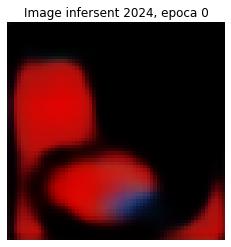

Epoch is: 1
Number of batches 505
Batch:505
d_loss:0.563762446081455
g_loss:[0.776743471622467, 0.7754006385803223, 0.0006714108167216182]


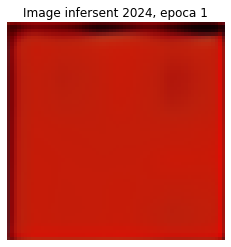

Epoch is: 2
Number of batches 505
Batch:505
d_loss:0.5496956263123138
g_loss:[0.7859911918640137, 0.7839146852493286, 0.0010382666951045394]


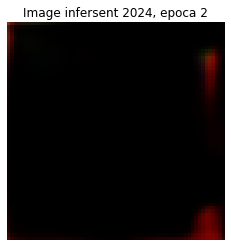

Epoch is: 3
Number of batches 505


In [0]:
batch_size=64
initial_epoch=51
epochs=800
run=1

real_labels = np.ones((batch_size, 1), dtype=float) * 0.9
fake_labels = np.zeros((batch_size, 1), dtype=float) * 0.1

for epoch in range(initial_epoch,epochs):
  print("========================================")
  print("Epoch is:", epoch)
  print("Number of batches", int(img_train.shape[0] / batch_size))

  gen_losses = []
  dis_losses = []

  number_of_batches = int(img_train.shape[0] / batch_size)
  for index in range(number_of_batches):
    #print("Batch:{}".format(index+1))

     # Create a batch of noise vectors
    z_noise = np.random.normal(0, 1, size=(batch_size, z_dim))
    image_batch = img_train[index * batch_size:(index + 1) * batch_size]
    embedding_batch = emb_train[index * batch_size:(index + 1) * batch_size]

    # Normalize images
    image_batch = image_batch/255 #(image_batch - 127.5) / 127.5

    fake_images, _ = stage1_gen.predict([embedding_batch, z_noise], verbose=3)
    
    #embedding compression
    #compressed_embedding = np.hstack((embedding_batch,embedding_batch))
    compressed_embedding = np.reshape(embedding_batch, (batch_size, 4, 4, condition_dim))

    #calc losses
    dis_loss_real = stage1_dis.train_on_batch([image_batch, compressed_embedding],np.reshape(real_labels, (batch_size, 1)))
    dis_loss_fake = stage1_dis.train_on_batch([fake_images, compressed_embedding],np.reshape(fake_labels, (batch_size, 1)))
    dis_loss_wrong = stage1_dis.train_on_batch([image_batch[:(batch_size - 1)], compressed_embedding[1:]],np.reshape(fake_labels[1:], (batch_size-1, 1)))

    g_loss = adversarial_model.train_on_batch([embedding_batch, z_noise, compressed_embedding],[K.ones((batch_size, 1)) * 0.9, K.ones((batch_size, 256)) * 0.9])

    d_loss = 0.5 * np.add(dis_loss_real, 0.5 * np.add(dis_loss_wrong, dis_loss_fake))

    if index%100 ==0:
      print("Batch:{}".format(index+1))
      print("d_loss:{}".format(d_loss))  
      print("g_loss:{}".format(g_loss))

    dis_losses.append(d_loss)
    gen_losses.append(g_loss)

  if epoch % 10 == 0:
    # empieza a guardar desde época 0
    print("Guardo 3 imagenes")                     
    z_noise2 = np.random.normal(0, 1, size=(batch_size, z_dim))
    embedding_batch = emb_test[0:batch_size]
    fake_images, _ = stage1_gen.predict_on_batch([embedding_batch, z_noise2])

    # Save images
    for i, img in enumerate(fake_images[:3]):
      save_rgb_img(img,"/content/drive/My Drive/red_infersent_2048/gen_{}_{}_{}.png".format(epoch, i,run),epoch)

  if epoch % 50 == 0:
    print("Guardo pesos")
    stage1_gen.save_weights("/content/drive/My Drive/red_infersent_2048/stage1_gen_{}.h5".format(epoch))
    stage1_dis.save_weights("/content/drive/My Drive/red_infersent_2048/stage1_dis_{}.h5".format(epoch))

In [0]:
#salva alguna imagenes

z_noise2 = np.random.normal(0, 1, size=(batch_size, z_dim))
embedding_batch = emb_test[0:batch_size]
fake_images, _ = stage1_gen.predict_on_batch([embedding_batch, z_noise2])

  # Save images
for i, img in enumerate(fake_images[:10]):
  save_rgb_img(img, "/content/drive/My Drive/fake_img/gen_{}_{}.png".format(epoch, i))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [0]:
# guarda los pesos de la red
stage1_gen.save_weights("/content/drive/My Drive/red_infersent_2048/stage1_gen_{}.h5".format(epoch))
stage1_dis.save_weights("/content/drive/My Drive/red_infersent_2048/stage1_gen_{}.h5".format(epoch))